
<div align='center'><font size="6" color="red"> Misinformation is one of the biggest issues in today's society</font></div>
<div align='center'><font size="4" color="red">And Fake news is a real problem


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<hr>

# Problem Statement

We have 2 datasets with Real News data and Fake News data. Each dataset has around 22000 articles. As we merge both, we have around 45000 articles of real and fake. The aim is to build a model to correctly predict if a news is real or fake.

# Table of Contents

1. [Import Packages](#import-packages)
2. [Read Data](#read-data)
    * [Create Target based on Real and Fake data](#create-target)
    * [Concat both real and fake data](#concat-data)
3. [Data Analysis](#data-analysis)
    * [Missing value Treatment](#treat-missing-value)
    * [Merge Title and Text data](#merge-title-text)
4. [Data Cleaning](#data-cleaning)
    * [Preprocessing Text to get Stemmed and Lemmatized Corpus](#Preprocess-text)
    * [WordCloud for label=1 -- Real News](#word-cloud-label-1)
    * [WordCloud for label=0 -- Fake News](#word-cloud-label-0)
5. [Classification models using CountVectorizer and TFIDF Vectorizer](#create-models)
    * [Using CountVectorizer and TFIDF Vectorizer with stemmed text](#counttfidf-stemmed)
    * [Using CountVectorizer and TFIDF Vectorizer with lemmatized text](#counttfidf-lemmatized)
6. [LSTM model using One Hot vector](#one-hot-vector-lstm)
    * [Using One hot representation and Stemmed Text](#one-hot-stemmed)
    * [Evaluate model](#stemmed-evaluate)
    * [Using One hot representation and Lemmatized Text](#one-hot-lemmatized)
    * [Evaluate model](#lemmatized-evaluate)
7. [Conclusion](#conclusion)



# Import Packages
<a id = "import-packages"></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import History

from wordcloud import WordCloud, STOPWORDS

# Read Data
<a id = "read-data"></a>

In [ ]:
#Bengali Dataset
dataset = pd.read_csv("/content/drive/MyDrive/research/totaldata.csv")
dataset.head()

,Unnamed: 0,articleID,content,headline,label
0,0,1,গত ১৭ সেপ্টেম্বর বাংলাদেশ কৃষি বিশ্ববিদ্যালয়ে ...,"হট্টগোল করায় বাকৃবিতে দুইজন বরখাস্ত, ৬ জনকে শোকজ",1
1,1,2,বাংলাদেশের বৃহৎ শ্রমবাজার মালয়েশিয়ায় আবার শ্রম...,মালয়েশিয়ায় কর্মী পাঠানোর ব্যবস্থা নেয়ার সুপারিশ,1
2,2,3,নরসিংদীর মনোহরদীতে প্রেমের প্রস্তাবে রাজি না হ...,প্রেমের প্রস্তাবে রাজি না হওয়ায় স্কুলছাত্রীকে ...,1
3,3,4,সুপ্রিম কোর্টের হাইকোর্ট বিভাগের বিচারপতি আহমে...,মেডিয়েশনই মামলাজট নিরসনের পথ : বিচারপতি আহমেদ ...,1
4,4,5,মাদারীপুর সদরের উপজেলার লেকেরপাড়ে একটি বেসরকার...,টকশোতে বক্তব্য দিতে গিয়ে জাপা নেতার মৃত্যু,1


In [ ]:
#real = pd.read_csv("/content/drive/MyDrive/DDD   Dataset/Fake News English dataset/True.csv")
#real.head()

In [ ]:
#fake = pd.read_csv("/content/drive/MyDrive/DDD   Dataset/Fake News English dataset/Fake.csv")
#fake.head()

**Create Target based on Real and Fake data**
<a id="create-target"></a>

In [ ]:
#real['Category'] = 1
#fake['Category'] = 0

In [ ]:
#print(real.shape)
#real.head()

In [ ]:
#print(fake.shape)
#fake.head()

**Concat both real and fake data**
<a id = "concat-data"></a>

In [ ]:
#dataset = pd.concat([real, fake]).reset_index(drop=True)

In [ ]:
print(dataset.shape)
dataset.head()

(11434, 5)


,Unnamed: 0,articleID,content,headline,label
0,0,1,গত ১৭ সেপ্টেম্বর বাংলাদেশ কৃষি বিশ্ববিদ্যালয়ে ...,"হট্টগোল করায় বাকৃবিতে দুইজন বরখাস্ত, ৬ জনকে শোকজ",1
1,1,2,বাংলাদেশের বৃহৎ শ্রমবাজার মালয়েশিয়ায় আবার শ্রম...,মালয়েশিয়ায় কর্মী পাঠানোর ব্যবস্থা নেয়ার সুপারিশ,1
2,2,3,নরসিংদীর মনোহরদীতে প্রেমের প্রস্তাবে রাজি না হ...,প্রেমের প্রস্তাবে রাজি না হওয়ায় স্কুলছাত্রীকে ...,1
3,3,4,সুপ্রিম কোর্টের হাইকোর্ট বিভাগের বিচারপতি আহমে...,মেডিয়েশনই মামলাজট নিরসনের পথ : বিচারপতি আহমেদ ...,1
4,4,5,মাদারীপুর সদরের উপজেলার লেকেরপাড়ে একটি বেসরকার...,টকশোতে বক্তব্য দিতে গিয়ে জাপা নেতার মৃত্যু,1


# Data Analysis
<a id = "data-analysis"></a>

**Missing value Treatment**
<a id = "treat-missing-value"></a>

In [ ]:
dataset.isnull().sum()

Unnamed: 0    0
articleID     0
content       0
headline      0
label         0
dtype: int64

As there is no missing value in the dataset, so we we can work directly on title and text columns

**Merge Title and Text data**
<a id = "merge-title-text"></a>

In [ ]:
dataset['final_text'] = dataset['headline'] + dataset['content']
dataset['final_text'].head()

0    হট্টগোল করায় বাকৃবিতে দুইজন বরখাস্ত, ৬ জনকে শো...
1    মালয়েশিয়ায় কর্মী পাঠানোর ব্যবস্থা নেয়ার সুপারি...
2    প্রেমের প্রস্তাবে রাজি না হওয়ায় স্কুলছাত্রীকে ...
3    মেডিয়েশনই মামলাজট নিরসনের পথ : বিচারপতি আহমেদ ...
4    টকশোতে বক্তব্য দিতে গিয়ে জাপা নেতার মৃত্যুমাদা...
Name: final_text, dtype: object

In [ ]:
#dataset['Category'].value_counts()

In [ ]:
#dataset[['Category','subject','final_text']].groupby(['Category','subject']).count()

In [ ]:
#plt.figure(figsize=(10,5))
#sns.countplot(x= "subject", hue = "Category", data=dataset)

# Data Cleaning
<a id = "data-cleaning"></a>

**Preprocessing Text to get Stemmed and Lemmatized Corpus**
<a id = "Preprocess-text"></a>

In this step we will clean the data that will be used for training. The cleaning will involve these steps-
1. Removing all the extra information like brackets, any kind of puctuations - commas, apostrophes, quotes, question marks, and more.
2. Remove all the numeric text, urls
3. Remove all the stop words like - just, and, or, but, if
4. Convert all the remaining text in the lower case, separated by space
5. Generate stemmed text
6. Generate lemmatized text

In [ ]:
!pip install bnltk

In [ ]:
!pip install git+https://github.com/banglakit/lemmatizer.git#egg=banglakit-lemmatizer

In [ ]:
from bnltk.stemmer import BanglaStemmer
from banglakit.lemmatizer import BengaliLemmatizer

In [ ]:
#porter_stemmer = PorterStemmer()
stemmer = BanglaStemmer()
#lemmatizer = WordNetLemmatizer()
lemmatizer = BengaliLemmatizer()

In [ ]:
#import nltk
#nltk.download('stopwords')
stopWords = []
with open('/content/drive/MyDrive/research/bengali', 'r', encoding="utf8") as f:
    for row in f:  # iterate over the rows in the file
        row = row.replace("\n", "")
        stopWords.append(row)

In [ ]:
#import nltk
#nltk.download('wordnet')

In [ ]:
stemmed_text = []
lemmatized_text = []
final_text_result = []
for text in dataset['final_text']:
    result = re.sub(r'[\u09E6-\u09EF]', ' ', text)
    result = result.split()
    result = [r for r in result if r not in set(stopWords)]
    stemmed_result = [stemmer.stem(r) for r in result]
    stemmed_text.append(" ".join(stemmed_result))
    lemmatized_result = [lemmatizer.lemmatize(r) for r in result]
    lemmatized_text.append(" ".join(lemmatized_result))

In [ ]:
print(len(stemmed_text))
print(len(lemmatized_text))

11434
11434


**WordCloud for label=1 -- Real News**
<a id = "word-cloud-label-1"></a>

In [ ]:
#plt.figure(figsize=(15,15))
#wc=WordCloud(max_words=2000, width=1600, height=700, stopwords=stopWords).generate("".join(dataset[dataset.label==1].final_text))
#plt.imshow(wc, interpolation="bilinear")

**WordCloud for label=0 -- Fake News**
<a id = "word-cloud-label-0"></a>

In [ ]:
#plt.figure(figsize=(15,15))
#wc=WordCloud(max_words=2000, width=1600, height=700, stopwords=STOPWORDS).generate("".join(dataset[dataset.Category==0].final_text))
#plt.imshow(wc, interpolation="bilinear")

# Classification models using CountVectorizer and TFIDF Vectorizer
<a id = "create-models"></a>


In [ ]:
def get_prediction(vectorizer, classifier, X_train, X_test, y_train, y_test):
    pipe = Pipeline([('vector', vectorizer),
                    ('model', classifier)])
    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuarcy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))
    plot_confusion_matrix(model, X_test, y_test, display_labels=['FAKE', 'REAL'], cmap='Greens', values_format="d")
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix: \n", cm)
    print("Classification Report: \n", classification_report(y_test, y_pred))

Below I am creating classification models in 2 steps-
1. Using stemmed text and both Count Vectorizer and TFIDF Vectorizer
1. Using lemmatized text and both Count Vectorizer and TFIDF Vectorizer

**Using CountVectorizer and TFIDF Vectorizer with stemmed text**
<a id="counttfidf-stemmed"></a>

******USING STEMMED TEXT********


 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
***********Usng Count Vectorizer****************


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuarcy: 94.4
Confusion Matrix: 
 [[ 309  111]
 [  81 2930]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.74      0.76       420
           1       0.96      0.97      0.97      3011

    accuracy                           0.94      3431
   macro avg       0.88      0.85      0.87      3431
weighted avg       0.94      0.94      0.94      3431

***********Usng TFIDF Vectorizer****************
Accuarcy: 93.15
Confusion Matrix: 
 [[ 223  197]
 [  38 2973]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.53      0.65       420
           1       0.94      0.99      0.96      3011

    accuracy                           0.93      3431
   macro avg       0.90      0.76      0.81      3431
weighted avg       0.93      0.93      0.92      3431



 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Accuarcy: 93.82
Confusion Matrix: 
 [[ 292  128]
 [  84 2927]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      0.70      0.73       420
           1       0.96      0.97      0.97      3011

    accuracy                           0.94      3431
   macro avg       0.87      0.83      0.85      3431
weighted avg       0.94      0.94      0.94      3431

***********Usng TFIDF Vectorizer****************


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Accuarcy: 95.31
Confusion Matrix: 
 [[ 333   87]
 [  74 2937]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.79      0.81       420
           1       0.97      0.98      0.97      3011

    accuracy                           0.95      3431
   macro avg       0.89      0.88      0.89      3431
weighted avg       0.95      0.95      0.95      3431



 MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(33,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
***********Usng Count Vectorizer****************
Accuarcy

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuarcy: 93.7
Confusion Matrix: 
 [[ 307  113]
 [ 103 2908]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.75      0.73      0.74       420
           1       0.96      0.97      0.96      3011

    accuracy                           0.94      3431
   macro avg       0.86      0.85      0.85      3431
weighted avg       0.94      0.94      0.94      3431

***********Usng TFIDF Vectorizer****************


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuarcy: 95.02
Confusion Matrix: 
 [[ 331   89]
 [  82 2929]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.79      0.79       420
           1       0.97      0.97      0.97      3011

    accuracy                           0.95      3431
   macro avg       0.89      0.88      0.88      3431
weighted avg       0.95      0.95      0.95      3431



 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=400, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
***********Usng Count Vectorizer****

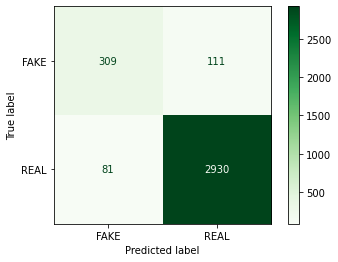

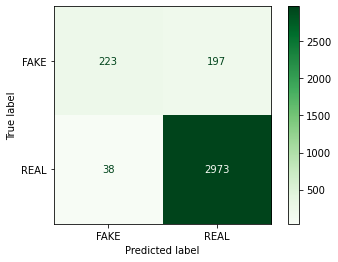

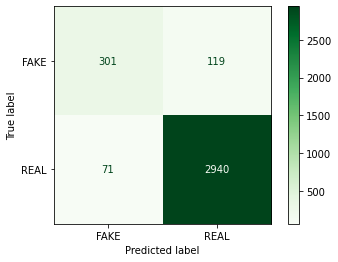

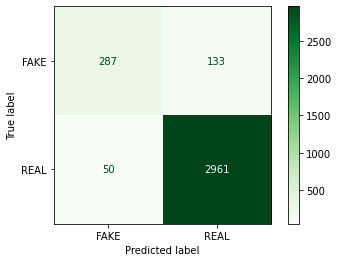

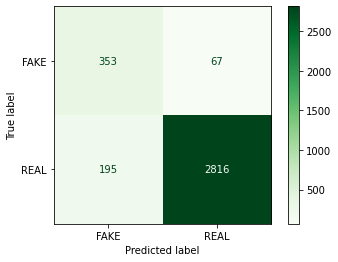

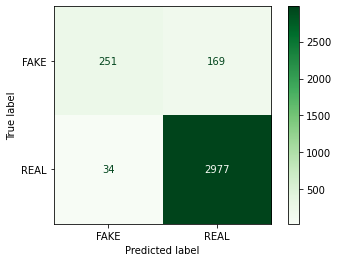

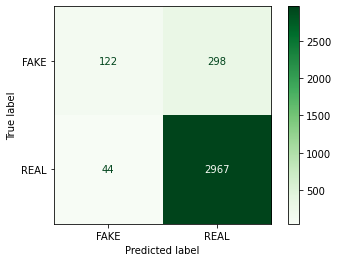

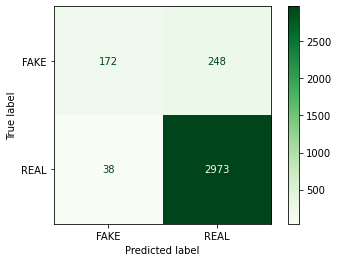

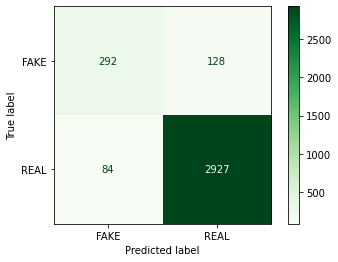

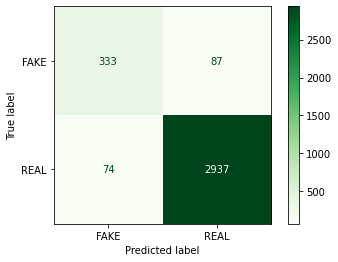

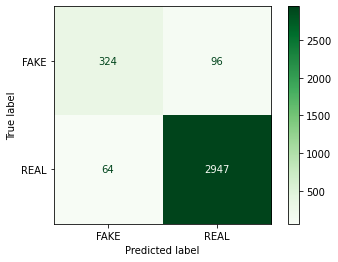

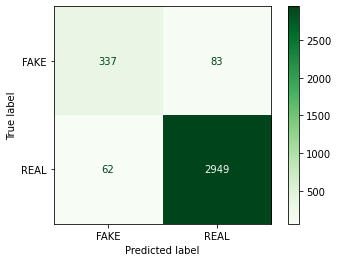

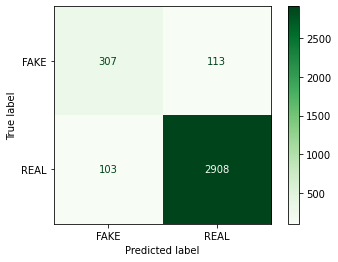

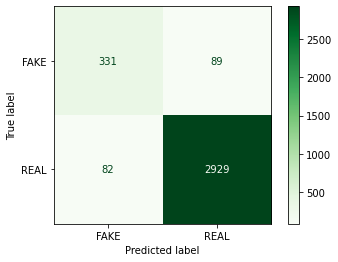

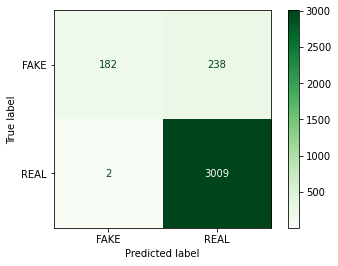

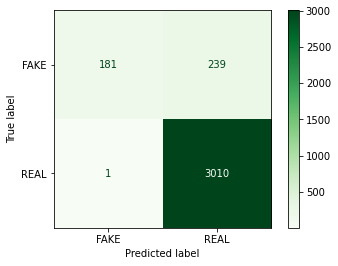

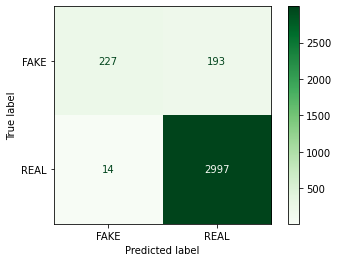

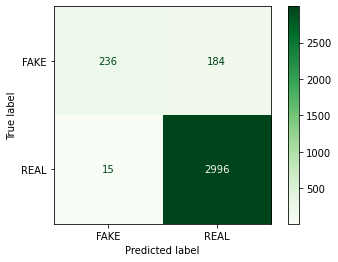

In [ ]:
print("******USING STEMMED TEXT********")
X_train, X_test, y_train, y_test = train_test_split(stemmed_text, dataset['label'], test_size = 0.3, random_state= 0)
classifiers = [LogisticRegression(), SGDClassifier(), MultinomialNB(alpha = 0.01), KNeighborsClassifier(7), PassiveAggressiveClassifier(max_iter=10), MLPClassifier(hidden_layer_sizes=(33,),max_iter=500), LinearSVC(C=100), 
               RandomForestClassifier(criterion='entropy', max_depth=400, random_state=0), XGBClassifier(), BernoulliNB()]
for classifier in classifiers:
    print("\n\n", classifier)
    print("***********Usng Count Vectorizer****************")
    get_prediction(CountVectorizer(), classifier, X_train, X_test, y_train, y_test)
    print("***********Usng TFIDF Vectorizer****************")
    get_prediction(TfidfVectorizer(), classifier, X_train, X_test, y_train, y_test)

**Using CountVectorizer and TFIDF Vectorizer with lemmatized text**
<a id="counttfidf-lemmatized"></a>

In [ ]:
from sklearn.model_selection import train_test_split

******USING LEMMATIZED TEXT********


 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
***********Usng Count Vectorizer****************


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuarcy: 94.46
Confusion Matrix: 
 [[ 310  110]
 [  80 2931]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.74      0.77       420
           1       0.96      0.97      0.97      3011

    accuracy                           0.94      3431
   macro avg       0.88      0.86      0.87      3431
weighted avg       0.94      0.94      0.94      3431

***********Usng TFIDF Vectorizer****************
Accuarcy: 92.95
Confusion Matrix: 
 [[ 215  205]
 [  37 2974]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.51      0.64       420
           1       0.94      0.99      0.96      3011

    accuracy                           0.93      3431
   macro avg       0.89      0.75      0.80      3431
weighted avg       0.93      0.93      0.92      3431



 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Accuarcy: 93.27
Confusion Matrix: 
 [[ 327   93]
 [ 138 2873]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.70      0.78      0.74       420
           1       0.97      0.95      0.96      3011

    accuracy                           0.93      3431
   macro avg       0.84      0.87      0.85      3431
weighted avg       0.94      0.93      0.93      3431

***********Usng TFIDF Vectorizer****************


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Accuarcy: 95.22
Confusion Matrix: 
 [[ 332   88]
 [  76 2935]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.79      0.80       420
           1       0.97      0.97      0.97      3011

    accuracy                           0.95      3431
   macro avg       0.89      0.88      0.89      3431
weighted avg       0.95      0.95      0.95      3431



 MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(33,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
***********Usng Count Vectorizer****************
Accuarcy

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuarcy: 94.17
Confusion Matrix: 
 [[ 314  106]
 [  94 2917]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.75      0.76       420
           1       0.96      0.97      0.97      3011

    accuracy                           0.94      3431
   macro avg       0.87      0.86      0.86      3431
weighted avg       0.94      0.94      0.94      3431

***********Usng TFIDF Vectorizer****************


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuarcy: 95.1
Confusion Matrix: 
 [[ 327   93]
 [  75 2936]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.78      0.80       420
           1       0.97      0.98      0.97      3011

    accuracy                           0.95      3431
   macro avg       0.89      0.88      0.88      3431
weighted avg       0.95      0.95      0.95      3431



 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=400, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
***********Usng Count Vectorizer*****

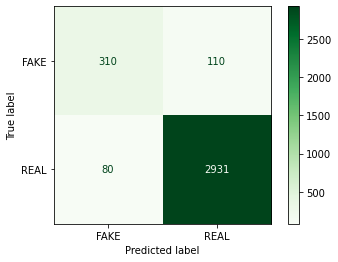

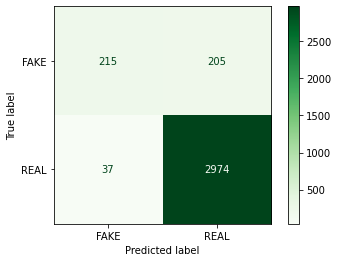

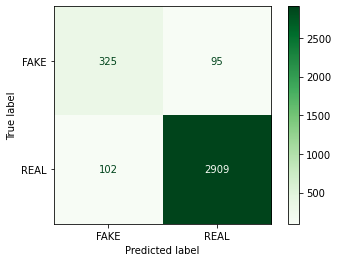

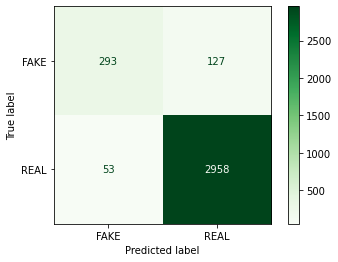

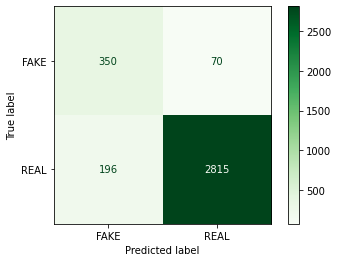

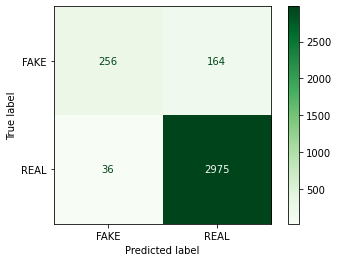

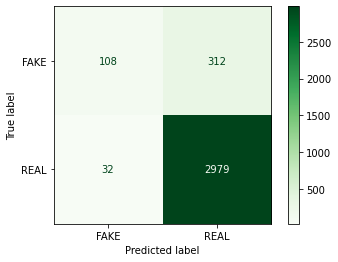

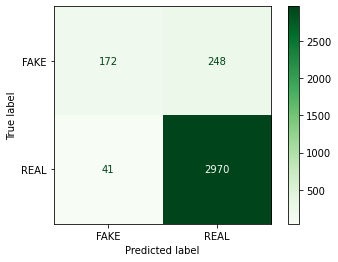

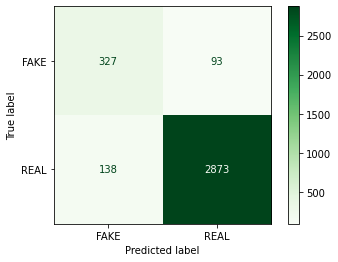

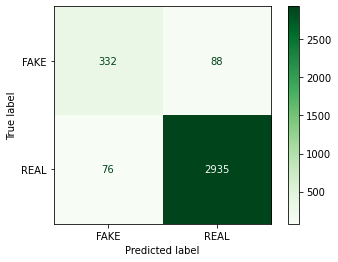

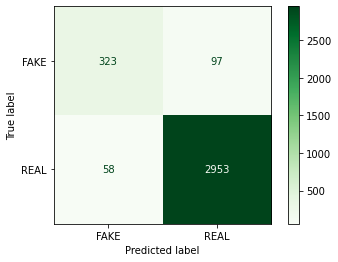

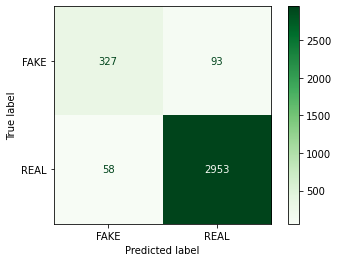

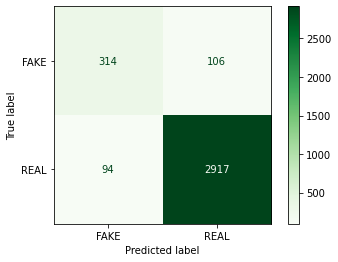

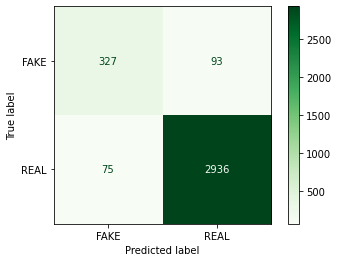

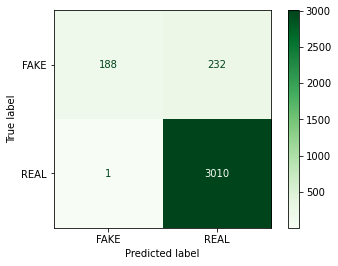

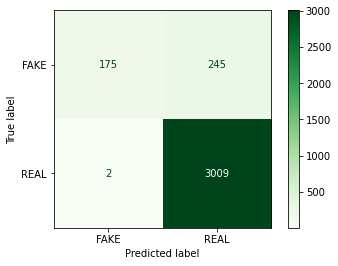

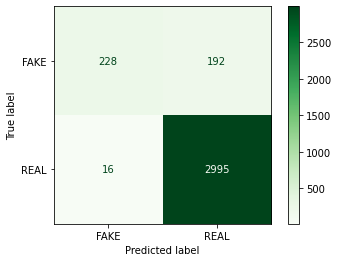

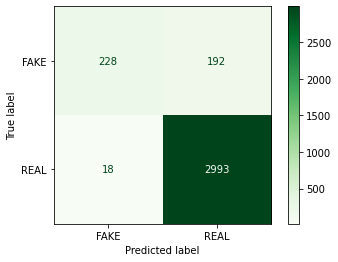

In [ ]:
print("******USING LEMMATIZED TEXT********")
X_train, X_test, y_train, y_test = train_test_split(lemmatized_text, dataset['label'], test_size = 0.3, random_state= 0)
classifiers = [LogisticRegression(), SGDClassifier(), MultinomialNB(alpha = 0.01), KNeighborsClassifier(7), PassiveAggressiveClassifier(max_iter=10), MLPClassifier(hidden_layer_sizes=(33,),max_iter=500), LinearSVC(C=100), 
               RandomForestClassifier(criterion='entropy', max_depth=400, random_state=0), XGBClassifier(), BernoulliNB()]
for classifier in classifiers:
    print("\n\n", classifier)
    print("***********Usng Count Vectorizer****************")
    get_prediction(CountVectorizer(), classifier, X_train, X_test, y_train, y_test)
    print("***********Usng TFIDF Vectorizer****************")
    get_prediction(TfidfVectorizer(), classifier, X_train, X_test, y_train, y_test)

After doing Predictive analysis above using both stemmed text and lemmatized text with Count Vectorizer and TFIDF Vectorizer, we see that the XGB Classifier is giving best results with lemmatized texts and Count Vectorizer with accuracy score of 99.78%

# LSTM model using One Hot vector 
<a id ="one-hot-vector-lstm"></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.5.0


**Using One hot representation and Stemmed Text**
<a id = "one-hot-stemmed"></a>

In [ ]:
voc_size = 5000
onehot_stemmed_text = [one_hot(word, voc_size) for word in stemmed_text]
print(len(onehot_stemmed_text))
onehot_stemmed_text[0]

11434


[741,
 166,
 3203,
 59,
 4209,
 3325,
 3706,
 1243,
 4071,
 77,
 3203,
 891,
 1063,
 741,
 1299,
 59,
 1810,
 4209,
 2397,
 3873,
 77,
 4217,
 2507,
 77,
 2947,
 507,
 3112,
 4330,
 3895,
 125,
 3544,
 1665,
 3472,
 514,
 2132,
 4092,
 3812,
 4855,
 1299,
 58,
 4584,
 3942,
 166,
 2076,
 3707,
 1995,
 176,
 60,
 412,
 675,
 1150,
 2371,
 278,
 1798,
 1810,
 4209,
 4327,
 1681,
 4244,
 2928,
 60,
 2131,
 1150,
 708,
 1963,
 2693,
 3866,
 412,
 4120,
 1150,
 935,
 4343,
 127,
 343,
 77,
 3490,
 639,
 1793,
 1260,
 2642,
 3013,
 1793,
 4106,
 3811,
 3555,
 708,
 4585,
 786,
 23,
 708,
 672,
 1795,
 4652,
 4613,
 705,
 2642,
 4318,
 178,
 3981,
 375,
 2928,
 1793,
 507,
 2642,
 3843,
 786,
 931,
 135,
 2917,
 2928,
 4742,
 507,
 4988,
 708,
 645,
 2787,
 1724,
 3544,
 1478,
 4217,
 3544,
 4706,
 3661,
 3461,
 3444,
 798,
 1426,
 891,
 212,
 1112,
 4720,
 891,
 1063,
 4878,
 4108,
 4244,
 1273,
 228,
 621,
 4411,
 4462,
 507,
 2348,
 891,
 3608,
 891,
 2712,
 4864,
 2759,
 2120,
 1824,
 142

In [ ]:
sent_length = 400
embedded_text = pad_sequences(onehot_stemmed_text, padding='pre', maxlen=sent_length)
print(embedded_text)

[[   0    0    0 ... 4370 2154 4371]
 [   0    0    0 ... 2505 2320  453]
 [   0    0    0 ...  139 1372 1902]
 ...
 [   0    0    0 ... 3953  270 2886]
 [   0    0    0 ... 4009  317  990]
 [   0    0    0 ...  934  444 2871]]


In [ ]:
embedding_vector_features = 600
model1 = Sequential()
model1.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
model1.add(LSTM(100))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 600)          3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               280400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 3,280,501
Trainable params: 3,280,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_final = np.array(embedded_text)
y_final = dataset['label']

In [ ]:
X_final.shape,y_final.shape

((11434, 400), (11434,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.3, random_state = 0)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, mode='auto')

In [ ]:
model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size = 256, callbacks=([reduce_lr, early_stop]))

Epoch 1/20
32/32 [==============================] - 16s 243ms/step - loss: 0.3804 - accuracy: 0.8632 - val_loss: 0.2255 - val_accuracy: 0.8919
Epoch 2/20
32/32 [==============================] - 7s 224ms/step - loss: 0.1378 - accuracy: 0.9463 - val_loss: 0.1697 - val_accuracy: 0.9309
Epoch 3/20
32/32 [==============================] - 7s 224ms/step - loss: 0.0573 - accuracy: 0.9846 - val_loss: 0.1772 - val_accuracy: 0.9417
Epoch 4/20
32/32 [==============================] - 7s 224ms/step - loss: 0.0173 - accuracy: 0.9975 - val_loss: 0.1979 - val_accuracy: 0.9432
Epoch 5/20
32/32 [==============================] - 7s 224ms/step - loss: 0.0062 - accuracy: 0.9994 - val_loss: 0.2121 - val_accuracy: 0.9403
Epoch 6/20
32/32 [==============================] - 7s 222ms/step - loss: 0.0027 - accuracy: 0.9998 - val_loss: 0.2307 - val_accuracy: 0.9379
Epoch 7/20
32/32 [==============================] - 7s 225ms/step - loss: 9.5032e-04 - accuracy: 1.0000 - val_loss: 0.2480 - val_accuracy: 0.9403



**Evaluate model**
<a id = "stemmed-evaluate"></a>

In [ ]:
y_pred = model1.predict_classes(X_test)
print("Accuarcy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuarcy: 94.4


In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", cm)

Confusion Matrix: 
 [[ 303  117]
 [  75 2936]]


In [ ]:
print("Classification Report: \n", classification_report(y_test, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.72      0.76       420
           1       0.96      0.98      0.97      3011

    accuracy                           0.94      3431
   macro avg       0.88      0.85      0.86      3431
weighted avg       0.94      0.94      0.94      3431



In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(cm,classes = ['Fake','Real'])

TypeError: ignored

**Using One hot representation and Lemmatized Text**
<a id = "one-hot-lemmatized"></a>

In [ ]:
voc_size = 5000
onehot_lemmatized_text = [one_hot(word, voc_size) for word in lemmatized_text]
print(len(onehot_lemmatized_text))
onehot_lemmatized_text[0]

In [ ]:
sent_length = 400
embedded_text = pad_sequences(onehot_lemmatized_text, padding='pre', maxlen=sent_length)
print(embedded_text)

In [ ]:
embedding_vector_features = 600
model2 = Sequential()
model2.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
model2.add(LSTM(100))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model2.summary()

In [ ]:
X_final = np.array(embedded_text)
y_final = dataset['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.3, random_state = 0)

In [ ]:
model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size = 256, callbacks=([reduce_lr, early_stop]))

**Evaluate model**
<a id = "lemmatized-evaluate"></a>

In [ ]:
y_pred = model2.predict_classes(X_test)
print("Accuarcy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", cm)

In [ ]:
print("Classification Report: \n", classification_report(y_test, y_pred))

In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(cm,classes = ['Fake','Real'])

With One hot vector and stemmed text LSTM model is giving 98.7 % accuracy.

# Conclusion
<a id="conclusion"></a>

Till this point, we are not getting any benefit in accuracy using LSTM model with Onehot vector. And XGBClassifier with CountVectorizer was giving better results.<br>
I will create another version of this dataset, where I will use the glove vector and bert.

**If you like the kernel please upvote.
If you have any questions/feedback feel free to comment and I will be happy to answer.
**